<a href="https://colab.research.google.com/github/saigokhale/Social-Bias-in-ER/blob/main/ER_Resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
import random
import shutil
import tarfile

%matplotlib inline

FER 2013 Dataset from Kaggle

In [3]:
import os
link="https://www.kaggle.com/datasets/jayeshrohansingh/emotion-detection-dataset/download?datasetVersionNumber=1"
#011960f626b19ef4ab6e3f9ffe8ba027
od.download(link, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saigokhale
Your Kaggle Key: ··········


100%|██████████| 151M/151M [00:02<00:00, 73.1MB/s]


In [4]:
DATA_DIR = '/content/emotion-detection-dataset/fer2013'

In [5]:
print(os.listdir(DATA_DIR+"/train"))

['Happy', 'Surprise', 'Neutral', 'Fear', 'Sad', 'Disgust', 'Angry']


In [6]:
class_labels=os.listdir(DATA_DIR+"/train")
sorted(class_labels)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [7]:
pretrained_size = 224 # 48*48

train_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.RandomRotation(5),
                           tt.RandomHorizontalFlip(0.5),
                           tt.ToTensor()
                          
                       ])

val_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor()
                       ])

test_transforms = tt.Compose([
                           tt.Resize((pretrained_size, pretrained_size)),
                           tt.ToTensor(),
                       ])

In [8]:
train_ds = ImageFolder(DATA_DIR+'/train', train_transforms)
valid_ds = ImageFolder(DATA_DIR+'/validation', val_transforms)
test_ds = ImageFolder(DATA_DIR+'/validation', test_transforms)

In [9]:
print(f'Number of training examples: {len(train_ds)}')
print(f'Number of validation examples: {len(valid_ds)}')
print(f'Number of testing examples: {len(test_ds)}')

Number of training examples: 28709
Number of validation examples: 3589
Number of testing examples: 3589


In [10]:
BATCH_SIZE = 64
train_dl = DataLoader(train_ds, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_dl = DataLoader(valid_ds, 
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

test_dl = DataLoader(test_ds, 
                                shuffle = True,
                                batch_size = BATCH_SIZE)

In [11]:
#WITHOUT LABELS
# def show_batch(dl):
#   for images, label in dl:
#       # print(images.shape)
#       fig, ax = plt.subplots(figsize=(12, 12))
#       ax.set_xticks([]); ax.set_yticks([])
#       grid_image=make_grid(images[:64],nrow=8)
#       # print(grid_image.shape)
#       ax.imshow(grid_image.permute(1,2,0))
#       print(label[:64].reshape(8,8))
#       break

def show_batch(dl, class_labels):
  for images, label in dl:
      fig = plt.figure(figsize=(12, 12))
      for i in range(images.shape[0]):
        ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
        ax.imshow(images[i].permute(1,2,0))
        ax.set_title(sorted(class_labels)[label[i]])
      break

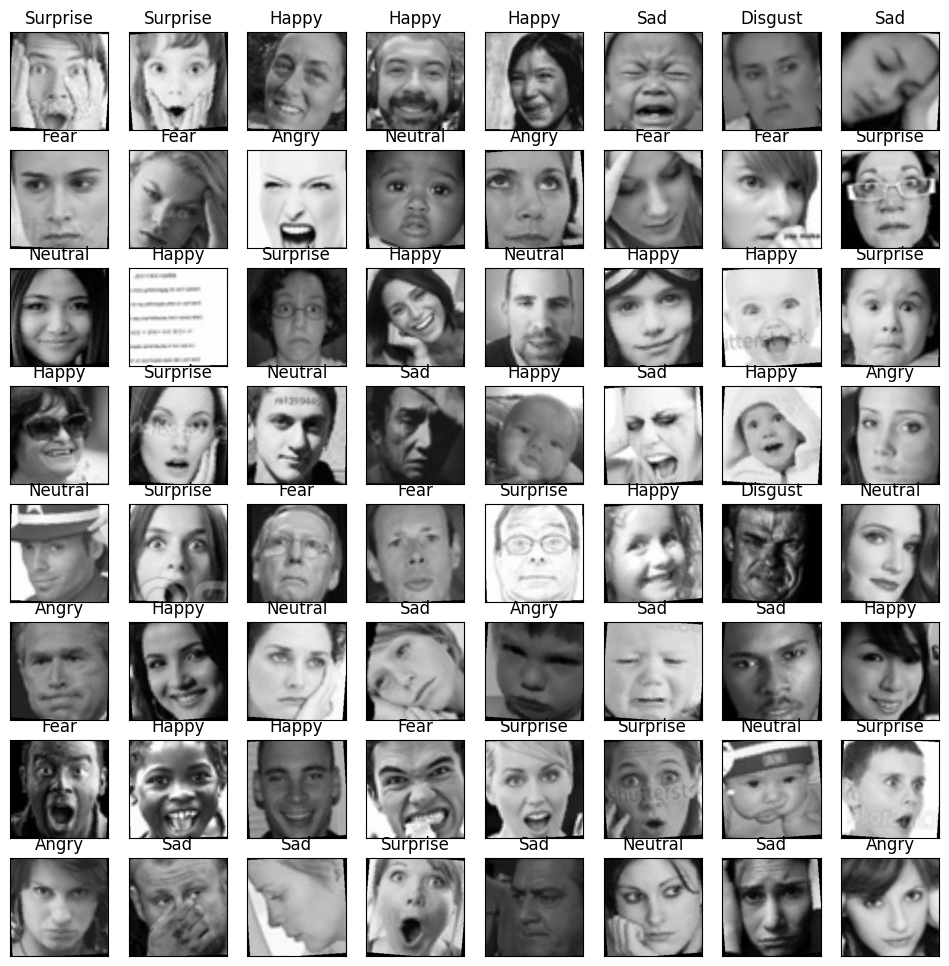

In [12]:
show_batch(train_dl, class_labels)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl2 = DeviceDataLoader(train_dl, device)
valid_dl2 = DeviceDataLoader(valid_dl, device)
test_dl2 = DeviceDataLoader(test_dl, device)

In [ ]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ERBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
from torchvision import models

class ERModel(ERBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = ERModel(len(train_ds.classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.4MB/s]


In [ ]:
to_device(model, device);


In [ ]:
history = [evaluate(model, valid_dl2)]
history

[{'val_loss': 2.074761152267456, 'val_acc': 0.11924342066049576}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam


In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl2, valid_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 1.3194, val_loss: 1.7568, val_acc: 0.4077


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.2850, val_loss: 1.8375, val_acc: 0.3957


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2295, val_loss: 1.5358, val_acc: 0.4385


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 1.1695, val_loss: 1.4741, val_acc: 0.4651


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 1.0683, val_loss: 1.3798, val_acc: 0.5287


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.9362, val_loss: 1.3623, val_acc: 0.5576
CPU times: user 13min 30s, sys: 58.1 s, total: 14min 28s
Wall time: 14min 37s


In [ ]:
epochs_2 = 10
lr_2 = 0.002
opt_func_2 = torch.optim.Adam

In [ ]:
%%time
history += fit(epochs_2, lr_2, model, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9938, val_loss: 1.4182, val_acc: 0.5100


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.9414, val_loss: 1.5160, val_acc: 0.5377


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.9020, val_loss: 1.4415, val_acc: 0.5355


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.8653, val_loss: 1.4767, val_acc: 0.5498


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.8220, val_loss: 1.5313, val_acc: 0.5618


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.7795, val_loss: 1.4807, val_acc: 0.5580


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7443, val_loss: 1.5423, val_acc: 0.5473


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.6998, val_loss: 1.5208, val_acc: 0.5635


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.6542, val_loss: 1.6179, val_acc: 0.5804


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.6087, val_loss: 1.7161, val_acc: 0.5512
CPU times: user 21min 59s, sys: 1min 37s, total: 23min 37s
Wall time: 23min 51s


In [ ]:
history += fit(epochs_2, lr_2, model, train_dl2, valid_dl2, opt_func=opt_func_2)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.5517, val_loss: 1.7548, val_acc: 0.5681


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.4987, val_loss: 1.8100, val_acc: 0.5655


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.4575, val_loss: 1.8809, val_acc: 0.5520


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4241, val_loss: 2.1054, val_acc: 0.5594


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3968, val_loss: 2.1890, val_acc: 0.5542


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.3588, val_loss: 2.2193, val_acc: 0.5719


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3332, val_loss: 2.2460, val_acc: 0.5650


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3100, val_loss: 2.3240, val_acc: 0.5761


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2730, val_loss: 2.4448, val_acc: 0.5666


  0%|          | 0/449 [00:00<?, ?it/s]

### MODEL 2 GradCAM

In [ ]:
NUM_CLASSES=len(class_labels)
GRAYSCALE=False

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ERBase2(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ERBase2, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas


def resnet34(num_classes):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=ERBase2, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [ ]:
model2 = resnet34(NUM_CLASSES)

In [ ]:
to_device(model2, device);

In [ ]:
import time
NUM_EPOCHS=6
LEARNING_RATE=0.0002
optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model2(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model2.train()
    for batch_idx, (features, targets) in enumerate(train_dl2):
        
        features = to_device(features, device)
        targets = to_device(targets, device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model2(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_dl2), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model2, train_dl2, device=device)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl2, valid_dl2, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 1.3194, val_loss: 1.7568, val_acc: 0.4077


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 1.2850, val_loss: 1.8375, val_acc: 0.3957


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.2295, val_loss: 1.5358, val_acc: 0.4385


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 1.1695, val_loss: 1.4741, val_acc: 0.4651


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 1.0683, val_loss: 1.3798, val_acc: 0.5287


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.9362, val_loss: 1.3623, val_acc: 0.5576
CPU times: user 13min 30s, sys: 58.1 s, total: 14min 28s
Wall time: 14min 37s
